# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Посмотрим на размер датасета
data.shape

(1460, 81)

Обучим три разные модели: **Random Forest**, **XGBoost** и **Linear Regression** на одинаковых тренировочных данных, сравним их на одних и тех же тестовых данных. Обучим стекинг этих моделей с помощью **Linear Regression** и сравним его метрики с остальными.

In [5]:
# Выделим категориальные и численные переменные
cat_features = list(data.dtypes[data.dtypes == object].index)
num_features = [f for f in data if f not in cat_features + ['Id', 'SalePrice']]

Подготовим данные для модели **Random Forest** и **XGBoost**:
- пропуски в числовых переменных заменим значениями, отличающимися от остальных, например, *-999*
- пропуски в категориальных переменных заменим значением *'nan'*
- категориальные переменные преобразуем с помощью **label encoding**

In [6]:
# Заменим пропуски в категориальных и числовых переменных
data_ensem_cat = data[cat_features].fillna('nan')
data_ensem_num = data[num_features].fillna(-999)

In [7]:
# Применим label encoding к категориальным переменным
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feat in data_ensem_cat.columns:
    data_ensem_cat[feat] = le.fit_transform(data_ensem_cat[feat])

In [8]:
# Датасет для моделей Random Forest и XGBoost
data_ensem = pd.concat([data_ensem_num, data_ensem_cat, data.SalePrice], axis=1)

In [9]:
data_ensem.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,1,4,4,2,3,4,4,8,4,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,1,4,4,2,3,4,4,8,4,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,1,4,4,2,3,4,4,8,4,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,2,4,4,2,3,4,4,8,0,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,1,4,4,2,3,4,4,8,4,250000


In [10]:
# Разделим данные на train и test с помощью флага is_train
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .75

In [11]:
train_index = data[data.is_train == True].index
test_index = data[data.is_train == False].index

In [12]:
# Тренировочные и тестовые данные целевой метки, общие для всех моделей
y_train, y_test = data.SalePrice[train_index], data.SalePrice[test_index]

In [13]:
# Тренировочные и тестовые данные для моделей Random Forest и XGBoost
X_rf_train = data_ensem.drop('SalePrice', axis=1).iloc[train_index]
X_rf_test = data_ensem.drop('SalePrice', axis=1).iloc[test_index]

In [14]:
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=20, max_features=0.5, n_jobs=-1,
                               random_state=2)
reg_rf.fit(X_rf_train, y_train)
y_rf_pred = reg_rf.predict(X_rf_test)

Метрики для модели **Random Forest**.

In [15]:
print('Random Forest')
print('MAE: ', mean_absolute_error(y_test, y_rf_pred))
print('RMSE: ', mean_squared_error(y_test, y_rf_pred, squared=False))
print('Variance score: ', r2_score(y_test, y_rf_pred))

Random Forest
MAE:  18462.822108488832
RMSE:  27406.364501397537
Variance score:  0.8789981716960111


Обучим модель **XGBoost** на тех же данных.

In [16]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

reg_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=300, objective='reg:squarederror', n_jobs=-1, random_state=2)
reg_xgb.fit(X_rf_train, y_train)
y_xgb_pred = reg_xgb.predict(X_rf_test)

Метрики для модели **XGBoost**.

In [17]:
print('XGBoost')
print('MAE: ', mean_absolute_error(y_test, y_xgb_pred))
print('RMSE: ', mean_squared_error(y_test, y_xgb_pred, squared=False))
print('Variance score: ', r2_score(y_test, y_xgb_pred))

XGBoost
MAE:  16225.153899721448
RMSE:  24572.653181824837
Variance score:  0.9027268061662268


Подготовим данные для линейной модели:
- пропуски в числовых переменных заменим медианами
- пропуски в категориальных переменных заменим значением *'nan'*
- числовые переменные нормируем
- категориальные переменные преобразуем с помощью one hot encoding

In [18]:
# Посмотрим на количество категориальных переменных, после преобразования с помощью one hot encoding
data[cat_features].nunique().sum() + len([x for x in data[cat_features].columns if data[x].isna().sum() != 0])

268

Для не большого датасета полученных 268 признаков только из категориальных очень много. Уменьшим их количество исходя из их важности для модели **Random Forest**.  

<font size="2"> Примечание - возможно, это не лучший подход, для отбора признаков для модели линейной регрессии, но он избавляет, если я правильно понимаю, от корррелированных  признаков и, если не гнаться за точностью, то для нас подходит.

In [19]:
headers = list(X_rf_train.columns.values)
feature_imp = pd.Series(reg_rf.feature_importances_, index=headers).sort_values(ascending=False)

In [20]:
cat_feat_lin = list(set(feature_imp[feature_imp > .001].index) & set(cat_features))

In [21]:
num_feat_lin = list(set(feature_imp[feature_imp > .001].index) & set(num_features))

In [22]:
# Посмотрим, сколько признаков мы получим
(data[cat_feat_lin].nunique().sum() + len([x for x in data[cat_feat_lin].columns if data[x].isna().sum() != 0]) + 
len(num_feat_lin))

58

In [23]:
# Вычислим медианы
median_lin = data[num_features].median()

In [24]:
data_lin_cat = data[cat_feat_lin].fillna('nan')
data_lin_num = data[num_feat_lin].fillna(median_lin)

In [25]:
dummy_cat = pd.get_dummies(data_lin_cat)

In [26]:
# Нормируем численные признаки
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_array = scaler.fit_transform(data_lin_num)

data_lin_num = pd.DataFrame(norm_array, columns = data_lin_num.columns)

In [27]:
# Датасет для модели Linear Regression
data_lin = pd.concat([data_lin_num, dummy_cat, data.SalePrice], axis=1)

In [28]:
data_lin.shape

(1460, 59)

In [29]:
X_lin_train = data_lin.drop('SalePrice', axis=1).iloc[train_index]
X_lin_test = data_lin.drop('SalePrice', axis=1).iloc[test_index]

In [30]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression().fit(X_lin_train, y_train)
y_lin_pred = reg_lin.predict(X_lin_test)

Метрики для модели **Linear Regression**.

In [31]:
print('Linear Regression model')
print('MAE: ', mean_absolute_error(y_test, y_lin_pred))
print('RMSE: ', mean_squared_error(y_test, y_lin_pred, squared=False))
print('Variance score: ', r2_score(y_test, y_lin_pred))

Linear Regression model
MAE:  20485.077994428968
RMSE:  28354.51755849375
Variance score:  0.870480965562085


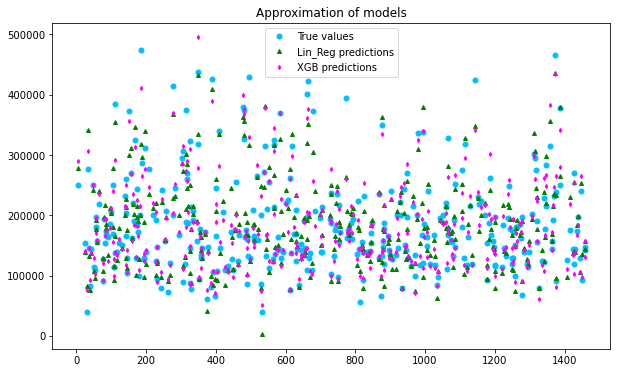

In [32]:
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, 'o', markersize = 5, color='deepskyblue', label='True values')
plt.plot(y_test.index, y_lin_pred, 'y^', markersize = 4, color='g', label='Lin_Reg predictions')
plt.plot(y_test.index, y_xgb_pred, 'd', markersize = 3, color='magenta', label='XGB predictions')
plt.legend()
plt.title('Approximation of models')
plt.show()

In [33]:
def get_meta_features(clf, X_train, y_train, X_test, y_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [34]:
# Обучим наши модели на кросс-валидации тренировочной выборки и посчитаем среднее от предсказаний по тестовой выборке
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=13, shuffle=False)

meta_train = []
meta_test = []
col_names = []

print('RF features...')
meta_tr, meta_te = get_meta_features(reg_rf, X_rf_train, y_train, X_rf_test, y_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('XGB features...')
meta_tr, meta_te = get_meta_features(reg_xgb, X_rf_train, y_train, X_rf_test, y_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('xgb_pred')

print('Linear Regression features...')
meta_tr, meta_te = get_meta_features(reg_lin, X_lin_train, y_train, X_lin_test, y_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lin_r_pred')

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


RF features...
XGB features...


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Linear Regression features...


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [35]:
# Датасет предсказаний моделей на тренировочной выборке
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
# Датасет предсказаний моделей на тестовой выборке
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

X_meta_train.head()

,rf_pred,xgb_pred,lin_r_pred
0,204925.024405,213759.750000,215884.000000
1,163656.724185,168230.515625,173281.000000
2,215233.346012,214707.484375,224614.525038
3,185519.002866,160368.875000,195955.250000
4,145335.824044,139875.906250,148227.000000


В качестве модели второго уровня используем линейную регрессию.

In [36]:
# Обучим на предсказаниях моделей на тренировочной выборке
reg_lin_meta = LinearRegression().fit(X_meta_train, y_train)
# Предскажем полученные предсказания моделей на тестовой выборке
y_meta_pred = reg_lin_meta.predict(X_meta_test)

In [37]:
print('Stacking of 3 learning algorithms')
print('MAE: ', mean_absolute_error(y_test, y_meta_pred))
print('RMSE: ', mean_squared_error(y_test, y_meta_pred, squared=False))
print('Variance score: ', r2_score(y_test, y_meta_pred))

Stacking of 3 learning algorithms
MAE:  15442.19481054702
RMSE:  23531.727389732576
Variance score:  0.9107934609181715


In [38]:
# Сравним коэффициент детерминации R^2 для разных моделей
print('Variance score for:')
print('Random Forest:     ', r2_score(y_test, y_rf_pred))
print('XGBoost:           ', r2_score(y_test, y_xgb_pred))
print('Linear Regression: ', r2_score(y_test, y_lin_pred))
print('Stacking:          ', r2_score(y_test, y_meta_pred))

Variance score for:
Random Forest:      0.8789981716960111
XGBoost:            0.9027268061662268
Linear Regression:  0.870480965562085
Stacking:           0.9107934609181715


P.S. Оценка сильно зависит от тестовых и тренировочных данных (разница до 0.1). Возможно, это связано с тем, что данные не были обработаны в полной мере перед обучением.